In [2]:
# В этом ноутбуке анализируем категории событий на роль кандидатов для определения действий,
# проводится визуальный анализ логов событий пользователей

In [1]:
import glob

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

DATA_PATH = '../../data/cosmetics_ecommerce_events'
RESULTS_PATH = '../../results'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #last_expr

In [2]:
df = pd.read_csv(f'{DATA_PATH}/2019-Oct.csv')

In [3]:
# Как показало предыдущее исследование, события "перемешаны", скорее всего не стоит пытаться 
# (по крайней мере на начальном этапе) исследовать последовательности событий с одним товаром.
# Поэтому разумно отказаться сразу от события удаления из корзины

df.shape

user_events = df[['user_id', 'user_session', 'event_time', 'product_id', 'event_type', 'price', 'category_id', 'brand']]

user_events = user_events[user_events['event_type'] != 'remove_from_cart']

user_events.shape

(4102283, 9)

(3340173, 8)

In [4]:
from IPython.core.interactiveshell import InteractiveShell
current_ast_node_interactivity = InteractiveShell.ast_node_interactivity
InteractiveShell.ast_node_interactivity = "last_expr"

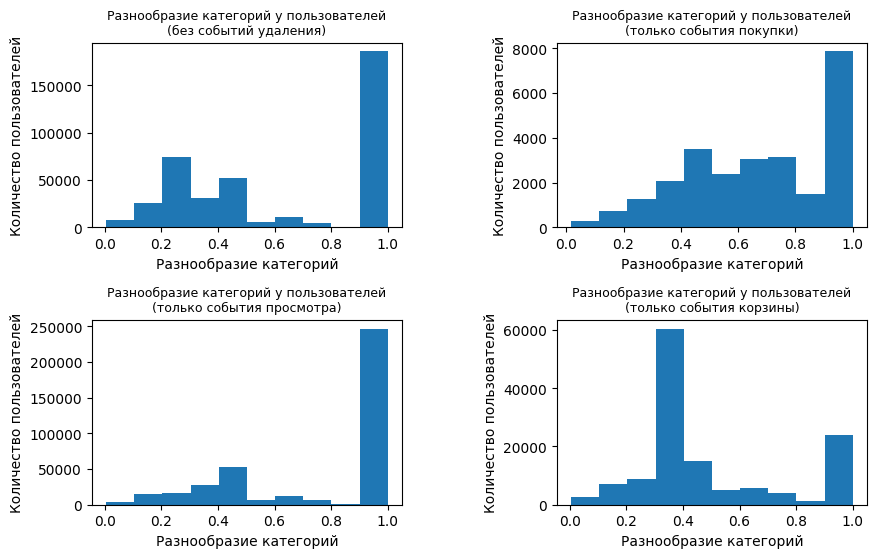

In [5]:
# У товаров разнообразие высокое, попробовать рассмотреть категории

# Разнообразие категорий по пользователям среди событий разного типа

# All
cat_div_df = user_events.groupby(['user_id'])['category_id'].agg(['nunique', 'count'])
cat_div_df['diversity'] = cat_div_df['nunique'] / cat_div_df['count']

fig = plt.figure(figsize=(10,6))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.subplot(221)
plt.hist(cat_div_df['diversity'])
plt.xlabel('Разнообразие категорий')
plt.ylabel('Количество пользователей')
plt.title('Разнообразие категорий у пользователей\n(без событий удаления)', size=9)

# Purchase
purchase_events = user_events[user_events['event_type'] == 'purchase']
cat_div_df = purchase_events.groupby(['user_id'])['category_id'].agg(['nunique', 'count'])
cat_div_df['diversity'] = cat_div_df['nunique'] / cat_div_df['count']

plt.subplot(222)
plt.hist(cat_div_df['diversity'])
plt.xlabel('Разнообразие категорий')
plt.ylabel('Количество пользователей')
plt.title('Разнообразие категорий у пользователей\n(только события покупки)', size=9)

# View
view_events = user_events[user_events['event_type'] == 'view']
cat_div_df = view_events.groupby(['user_id'])['category_id'].agg(['nunique', 'count'])
cat_div_df['diversity'] = cat_div_df['nunique'] / cat_div_df['count']

plt.subplot(223)
plt.hist(cat_div_df['diversity'])
plt.xlabel('Разнообразие категорий')
plt.ylabel('Количество пользователей')
plt.title('Разнообразие категорий у пользователей\n(только события просмотра)', size=9)

#Cart
cart_events = user_events[user_events['event_type'] == 'cart']
cat_div_df = cart_events.groupby(['user_id'])['category_id'].agg(['nunique', 'count'])
cat_div_df['diversity'] = cat_div_df['nunique'] / cat_div_df['count']

plt.subplot(224)
plt.hist(cat_div_df['diversity'])
plt.xlabel('Разнообразие категорий')
plt.ylabel('Количество пользователей')
plt.title('Разнообразие категорий у пользователей\n(только события корзины)', size=9)

plt.savefig(f'{RESULTS_PATH}/category_diversity.png', dpi=300)

In [6]:
# Хороший результат на первый взгляд - немало пользователей с малым разнообразием категорий

In [7]:
InteractiveShell.ast_node_interactivity = current_ast_node_interactivity

In [8]:
# events counts
purchase_events = user_events[user_events['event_type'] == 'purchase']
purchase_events_count_per_user = purchase_events.groupby(['user_id'])['event_type'].count()\
    .rename('purchase_events_count')
purchase_events_count_per_user.shape

view_events = user_events[user_events['event_type'] == 'view']
view_events_count_per_user = view_events.groupby(['user_id'])['event_type'].count()\
    .rename('view_events_count')
view_events_count_per_user.shape

cart_events = user_events[user_events['event_type'] == 'cart']
cart_events_count_per_user = cart_events.groupby(['user_id'])['event_type'].count()\
    .rename('cart_events_count')
cart_events_count_per_user.shape

events_count_per_user = user_events.groupby(['user_id'])['event_type'].count()
events_count_per_user.shape

# join counts
events_count_per_user_df = events_count_per_user.to_frame().rename(columns={'event_type': 'events_count'})

user_stats = events_count_per_user_df.merge(purchase_events_count_per_user, how='left', left_index=True, right_index=True).fillna(0)
user_stats['purchase_fraction'] =  user_stats['purchase_events_count']/user_stats['events_count']
user_stats.shape

user_stats = user_stats.merge(view_events_count_per_user, how='left', left_index=True, right_index=True).fillna(0)
user_stats['view_fraction'] =  user_stats['view_events_count']/user_stats['events_count']
user_stats.shape

user_stats = user_stats.merge(cart_events_count_per_user, how='left', left_index=True, right_index=True).fillna(0)
user_stats['cart_fraction'] =  user_stats['cart_events_count']/user_stats['events_count']
user_stats.shape

user_stats['log10_events_count'] = np.log10(user_stats['events_count'])


(25762,)

(388331,)

(133818,)

(399063,)

(399063, 3)

(399063, 5)

(399063, 7)

In [9]:
# compute diversity

user_category_stat = user_events.groupby(['user_id'])['category_id'].agg(['nunique', 'count'])
user_category_stat['category_diversity'] = user_category_stat['nunique'] / user_category_stat['count']
user_category_stat = user_category_stat.rename(columns={'nunique': 'category_nunique', 'count': 'category_count'})
user_category_stat.shape

purchase_user_category_stat = purchase_events.groupby(['user_id'])['category_id'].agg(['nunique', 'count'])
purchase_user_category_stat['purchased_category_diversity'] = \
    purchase_user_category_stat['nunique'] / purchase_user_category_stat['count']
purchase_user_category_stat = purchase_user_category_stat\
    .rename(columns={'nunique': 'purchased_category_nunique', 'count': 'purchased_category_count'})
purchase_user_category_stat.shape

view_user_category_stat = view_events.groupby(['user_id'])['category_id'].agg(['nunique', 'count'])
view_user_category_stat['view_category_diversity'] = \
    view_user_category_stat['nunique'] / view_user_category_stat['count']
view_user_category_stat = view_user_category_stat\
    .rename(columns={'nunique': 'view_category_nunique', 'count': 'view_category_count'})
view_user_category_stat.shape

cart_user_category_stat = cart_events.groupby(['user_id'])['category_id'].agg(['nunique', 'count'])
cart_user_category_stat['cart_category_diversity'] = \
    cart_user_category_stat['nunique'] / cart_user_category_stat['count']
cart_user_category_stat = cart_user_category_stat\
    .rename(columns={'nunique': 'cart_category_nunique', 'count': 'cart_category_count'})
cart_user_category_stat.shape

user_category_stat = user_category_stat.merge(purchase_user_category_stat, how='left', left_index=True, right_index=True)
user_category_stat.shape

user_category_stat = user_category_stat.merge(view_user_category_stat, how='left', left_index=True, right_index=True)
user_category_stat.shape

user_category_stat = user_category_stat.merge(cart_user_category_stat, how='left', left_index=True, right_index=True)
user_category_stat.shape

user_stats = user_stats.merge(user_category_stat, how='inner', left_index=True, right_index=True)
user_stats.shape

user_stats[~user_stats['purchased_category_diversity'].isna()]


(399063, 3)

(25762, 3)

(388331, 3)

(133818, 3)

(399063, 6)

(399063, 9)

(399063, 12)

(399063, 20)

events_count  purchase_events_count  purchase_fraction  \
user_id                                                             
29025780             50                   18.0           0.360000   
31229488             38                    4.0           0.105263   
33535391             41                   11.0           0.268293   
33609704             51                    9.0           0.176471   
34080306             36                    3.0           0.083333   
...                 ...                    ...                ...   
566264460            34                    6.0           0.176471   
566270279            31                    6.0           0.193548   
566270544             3                    1.0           0.333333   
566272734            21                    7.0           0.333333   
566274213             5                    1.0           0.200000   

           view_events_count  view_fraction  cart_events_count  cart_fraction  \
user_id                                                                         
29025780                 3.0       0.060000               29.0       0.580000   
31229488                27.0       0.710526                7.0       0.184211   
33535391                16.0       0.390244               14.0       0.341463   
33609704                30.0       0.588235               12.0       0.235294   
34080306                22.0       0.611111               11.0       0.305556   
...                      ...            ...                ...            ...   
566264460               20.0       0.588235                8.0       0.235294   
566270279                9.0       0.290323               16.0       0.516129   
566270544                1.0       0.333333                1.0       0.333333   
566272734                7.0       0.333333                7.0       0.333333   
566274213                2.0       0.400000                2.0       0.400000   

           log10_events_count  category_nunique  category_count  \
user_id                                                           
29025780             1.698970                12              50   
31229488             1.579784                 4              38   
33535391             1.612784                11              41   
33609704             1.707570                10              51   
34080306             1.556303                 7              36   
...                       ...               ...             ...   
566264460            1.531479                 8              34   
566270279            1.491362                13              31   
566270544            0.477121                 1               3   
566272734            1.322219                 2              21   
566274213            0.698970                 1               5   

           category_diversity  purchased_category_nunique  \
user_id                                                     
29025780             0.240000                        10.0   
31229488             0.105263                         2.0   
33535391             0.268293                         7.0   
33609704             0.196078                         6.0   
34080306             0.194444                         2.0   
...                       ...                         ...   
566264460            0.235294                         5.0   
566270279            0.419355                         5.0   
566270544            0.333333                         1.0   
566272734            0.095238                         2.0   
566274213            0.200000                         1.0   

           purchased_category_count  purchased_category_diversity  \
user_id                                                             
29025780                       18.0                      0.555556   
31229488                        4.0                      0.500000   
33535391                       11.0                      0.636364   
33609704                        9.0             

In [10]:
user_stat_columns_df = pd.DataFrame(user_stats.columns)
user_stat_columns_df.to_csv(f'{RESULTS_PATH}/user_stat_columns.csv', header=False)

In [11]:
from IPython.core.interactiveshell import InteractiveShell
current_ast_node_interactivity = InteractiveShell.ast_node_interactivity
InteractiveShell.ast_node_interactivity = "last_expr"

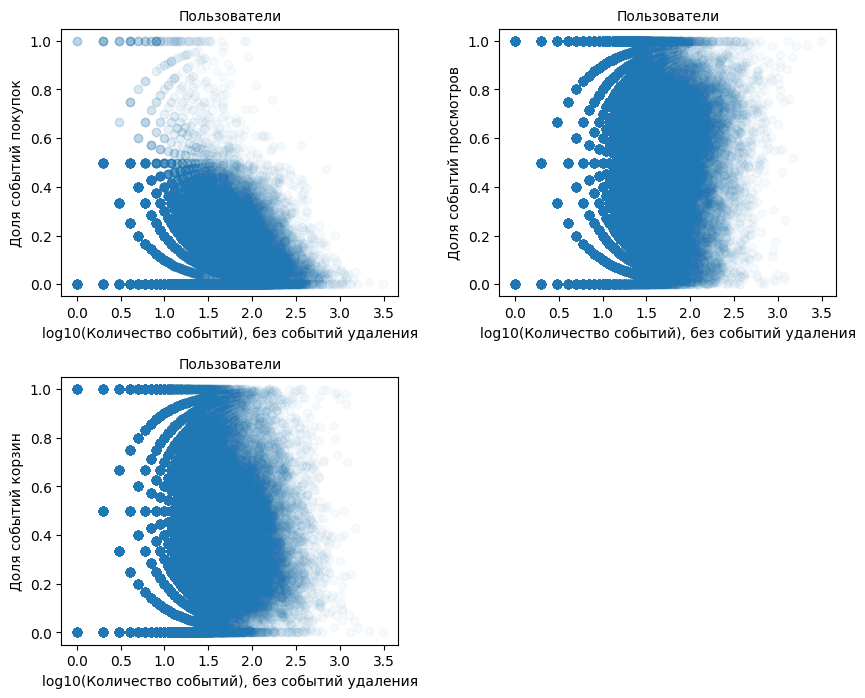

In [12]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.subplot(221)
plt.xlabel('log10(Количество событий), без событий удаления')
plt.ylabel('Доля событий покупок')
plt.title('Пользователи', size=10)
plt.scatter(user_stats['log10_events_count'], user_stats['purchase_fraction'], alpha=0.03)

plt.subplot(222)
plt.xlabel('log10(Количество событий), без событий удаления')
plt.ylabel('Доля событий просмотров')
plt.title('Пользователи', size=10)
plt.scatter(user_stats['log10_events_count'], user_stats['view_fraction'], alpha=0.03)

plt.subplot(223)
plt.xlabel('log10(Количество событий), без событий удаления')
plt.ylabel('Доля событий корзин')
plt.title('Пользователи', size=10)
plt.scatter(user_stats['log10_events_count'], user_stats['cart_fraction'], alpha=0.03)

plt.savefig(f'{RESULTS_PATH}/events_fraction.png', dpi=300)

In [13]:
InteractiveShell.ast_node_interactivity = current_ast_node_interactivity

In [14]:
# можно ли найти пользователя с большим числом событий, немалой долей покупок и низким разнообразием

predicate = (user_stats['cart_category_diversity'] < 0.1)\
  & (user_stats['cart_events_count'] > 100)\
  & (user_stats['cart_fraction'] <= 0.5)
len(user_stats[predicate])

selected = user_stats[predicate]
selected.shape
selected[['events_count', 'cart_events_count', 'cart_fraction', 'cart_category_diversity',\
          'cart_category_nunique', 'cart_category_count']]

selected[:10].T.to_csv(f'{RESULTS_PATH}/top_10_selected_users.csv', header=True)


28

(28, 20)

events_count  cart_events_count  cart_fraction  \
user_id                                                     
276624000           612              170.0       0.277778   
321298686           364              138.0       0.379121   
374479310           467              200.0       0.428266   
462431850           270              112.0       0.414815   
468573037           581              147.0       0.253012   
472137016           268              115.0       0.429104   
475107397           459              207.0       0.450980   
485480222           362              160.0       0.441989   
490479008           522              196.0       0.375479   
501921450           316              108.0       0.341772   
511871925           291              118.0       0.405498   
526462340           302              149.0       0.493377   
533267875          1107              442.0       0.399277   
534841205           334              161.0       0.482036   
538470291           737              261.0       0.354138   
547689928           325              128.0       0.393846   
550752696          1340              323.0       0.241045   
552235561           386              144.0       0.373057   
553861723           592              187.0       0.315878   
553947378           472              215.0       0.455508   
557316433           518              122.0       0.235521   
557777965           356              135.0       0.379213   
558190301           394              177.0       0.449239   
558397496           494              137.0       0.277328   
560619110           495              189.0       0.381818   
562400323           312              132.0       0.423077   
564342908           314              143.0       0.455414   
565044614           836              331.0       0.395933   

           cart_category_diversity  cart_category_nunique  cart_category_count  
user_id                                                                         
276624000                 0.070588                   12.0                170.0  
321298686                 0.065217                    9.0                138.0  
374479310                 0.090000                   18.0                200.0  
462431850                 0.044643                    5.0                112.0  
468573037                 0.068027                   10.0                147.0  
472137016                 0.086957                   10.0                115.0  
475107397                 0.053140                   11.0                207.0  
485480222                 0.087500                   14.0                160.0  
490479008                 0.061224                   12.0                196.0  
501921450                 0.064815                    7.0                108.0  
511871925                 0.059322                    7.0                118.0  
526462340                 0.060403                    9.0                149.0  
533267875                 0.090498                   40.0                442.0  
534841205                 0.055901                    9.0                161.0  
538470291                 0.088123                   23.0                261.0  
547689928                 0.054688                    7.0                128.0  
550752696                 0.040248                   13.0                323.0  
552235561                 0.034722                    5.0                144.0  
553861723                 0.064171                   12.0                187.0  
553947378                 0.041860                    9.0                215.0  
557316433                 0.057377                    7.0                122.0  
557777965                 0.029630                    4.0                135.0  
558190301                 0.067797                   12.0                177.0  
558397496                 0.065693                    9.0                137.0  
560619110                 0.052910                   10.0                1

(459, 8)

/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'События по времени')

Text(0.5, 23.52222222222222, 'Время, сек')

Text(0.9722222222222161, 0.5, 'Тип события')

/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 14.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


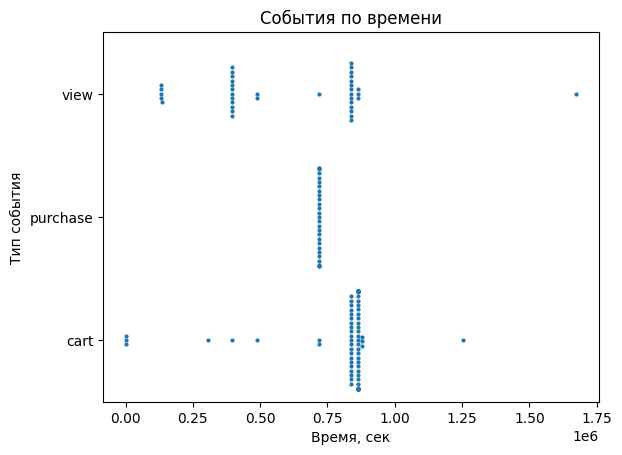

In [19]:
np.random.seed(1)
user_id = 475107397
selected_user_events = user_events[user_events['user_id'] == 475107397]
# todo: пользователей, которые будут отобраны

selected_user_events.shape

selected_user_events['event_time'] = pd.to_datetime(selected_user_events['event_time'])

selected_user_events = selected_user_events.sort_values(by=['event_time'], kind='mergesort')

selected_user_events['time_delta'] = selected_user_events['event_time'] - selected_user_events.iloc[0]['event_time']
selected_user_events['time_delta_sec'] = selected_user_events['time_delta'].apply(lambda x: x.total_seconds())

total_events = selected_user_events.shape[0]
select_events_count = int(total_events * 0.3) if total_events * 0.3 > 50 else 50
selected_user_events = selected_user_events.iloc[np.random.choice(total_events, select_events_count, replace=False)]

#selected_user_events['time_delta_sec'] = selected_user_events['time_delta_sec']
ax = sns.swarmplot(data=selected_user_events, x="time_delta_sec", y="event_type", size=3)
ax.set_title('События по времени')
ax.set_xlabel('Время, сек')
ax.set_ylabel('Тип события')

plt.savefig(f'{RESULTS_PATH}/user_{user_id}_events_swarmplot.png', dpi=300)

In [20]:
from IPython.core.interactiveshell import InteractiveShell
current_ast_node_interactivity = InteractiveShell.ast_node_interactivity
InteractiveShell.ast_node_interactivity = "last_expr"

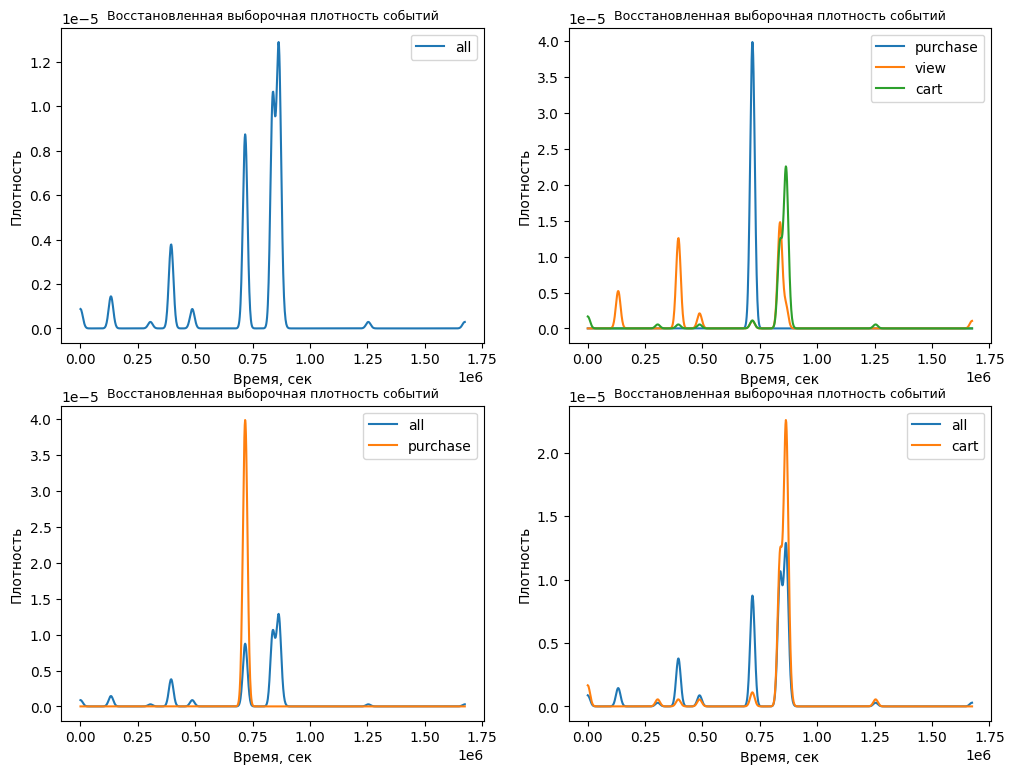

In [22]:
from sklearn.neighbors import KernelDensity

np.random.seed(1)

purchase_user_events = selected_user_events[selected_user_events['event_type'] == 'purchase']
view_user_events = selected_user_events[selected_user_events['event_type'] == 'view']
cart_user_events = selected_user_events[selected_user_events['event_type'] == 'cart']

x = selected_user_events[['time_delta_sec']]
x_purchase = purchase_user_events[['time_delta_sec']]
x_view = view_user_events[['time_delta_sec']]
x_cart = cart_user_events[['time_delta_sec']]

kde = KernelDensity(kernel='gaussian', bandwidth=10000).fit(x)
kde_purchase = KernelDensity(kernel='gaussian', bandwidth=10000).fit(x_purchase)
kde_view = KernelDensity(kernel='gaussian', bandwidth=10000).fit(x_view)
kde_cart = KernelDensity(kernel='gaussian', bandwidth=10000).fit(x_cart)

space = np.linspace(min(x['time_delta_sec']), max(x['time_delta_sec']), 1000).reshape(-1, 1)
log_density = kde.score_samples(space)
log_density_purchase = kde_purchase.score_samples(space)
log_density_view = kde_view.score_samples(space)
log_density_cart = kde_cart.score_samples(space)

fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.plot(space, np.exp(log_density), label='all')
plt.legend()
plt.xlabel('Время, сек')
plt.ylabel('Плотность')
plt.title('Восстановленная выборочная плотность событий', size=9)

plt.subplot(222)
plt.plot(space, np.exp(log_density_purchase), label='purchase')
plt.plot(space, np.exp(log_density_view), label='view')
plt.plot(space, np.exp(log_density_cart), label='cart')
plt.legend()
plt.xlabel('Время, сек')
plt.ylabel('Плотность')
plt.title('Восстановленная выборочная плотность событий', size=9)

plt.subplot(223)
plt.plot(space, np.exp(log_density), label='all')
plt.plot(space, np.exp(log_density_purchase), label='purchase')
plt.legend()
plt.xlabel('Время, сек')
plt.ylabel('Плотность')
plt.title('Восстановленная выборочная плотность событий', size=9)

plt.subplot(224)
plt.plot(space, np.exp(log_density), label='all')
plt.plot(space, np.exp(log_density_cart), label='cart')
plt.legend()
plt.xlabel('Время, сек')
plt.ylabel('Плотность')
plt.title('Восстановленная выборочная плотность событий', size=9)

plt.savefig(f'{RESULTS_PATH}/user_{user_id}_events_density.png', dpi=300)

In [23]:
InteractiveShell.ast_node_interactivity = current_ast_node_interactivity

In [24]:
user_id = 475107397
one_user_events = user_events[user_events['user_id'] == user_id]
one_user_events = one_user_events[['event_time', 'category_id', 'event_type']]
one_user_events['event_time'] = pd.to_datetime(one_user_events['event_time'])

one_user_events = one_user_events[one_user_events['event_type'] == 'cart']
one_user_events.shape

pd.set_option('display.max_rows', len(one_user_events))
one_user_events = one_user_events.sort_values(by=['event_time'])
one_user_events
pd.reset_option('display.max_rows')

(207, 3)

event_time          category_id event_type
1224345 2019-10-09 06:19:54+00:00  1487580009336930331       cart
1224347 2019-10-09 06:19:54+00:00  1487580009336930331       cart
1224348 2019-10-09 06:19:54+00:00  1487580009336930331       cart
1224357 2019-10-09 06:19:57+00:00  1487580009336930331       cart
1224360 2019-10-09 06:19:58+00:00  1487580009336930331       cart
1456176 2019-10-10 18:56:06+00:00  1487580009336930331       cart
1456179 2019-10-10 18:56:06+00:00  1487580009336930331       cart
1456181 2019-10-10 18:56:07+00:00  1487580009336930331       cart
1456774 2019-10-10 19:00:04+00:00  2140803113261466607       cart
1456831 2019-10-10 19:00:38+00:00  2140803113261466607       cart
1464087 2019-10-10 19:54:09+00:00  2195085255034011676       cart
1464266 2019-10-10 19:55:41+00:00  1487580007281722301       cart
1686333 2019-10-12 18:57:40+00:00  1487580010100293687       cart
1809198 2019-10-13 19:55:42+00:00  1487580009336930331       cart
1956132 2019-10-14 21:37:26+00:00  1487580008145748965       cart
2301394 2019-10-17 13:31:18+00:00  1487580009336930331       cart
2301849 2019-10-17 13:34:51+00:00  1487580007852147670       cart
2302053 2019-10-17 13:36:21+00:00  1487580007852147670       cart
2302062 2019-10-17 13:36:23+00:00  1487580007852147670       cart
2478184 2019-10-18 22:42:41+00:00  1487580007675986893       cart
2478188 2019-10-18 22:42:50+00:00  1487580007675986893       cart
2478209 2019-10-18 22:43:12+00:00  1487580007675986893       cart
2478218 2019-10-18 22:43:29+00:00  1487580007675986893       cart
2478226 2019-10-18 22:43:40+00:00  1487580007675986893       cart
2478234 2019-10-18 22:43:52+00:00  1487580007675986893       cart
2478259 2019-10-18 22:44:28+00:00  1487580007675986893       cart
2478360 2019-10-18 22:46:22+00:00  1487580007432717250       cart
2478471 2019-10-18 22:49:41+00:00  1487580007675986893       cart
2478473 2019-10-18 22:49:44+00:00  1487580007675986893       cart
2478483 2019-10-18 22:49:59+00:00  1487580007675986893       cart
2478484 2019-10-18 22:50:02+00:00  1487580007675986893       cart
2478495 2019-10-18 22:50:24+00:00  1487580007675986893       cart
2478565 2019-10-18 22:52:09+00:00  1487580007675986893       cart
2478582 2019-10-18 22:52:34+00:00  1487580007675986893       cart
2478596 2019-10-18 22:52:51+00:00  1487580007675986893       cart
2478611 2019-10-18 22:53:16+00:00  1487580007675986893       cart
2478616 2019-10-18 22:53:38+00:00  1487580007675986893       cart
2478628 2019-10-18 22:54:23+00:00  1487580007675986893       cart
2478630 2019-10-18 22:54:25+00:00  1487580007675986893       cart
2478631 2019-10-18 22:54:27+00:00  1487580007675986893       cart
2478636 2019-10-18 22:54:41+00:00  1487580007675986893       cart
2478638 2019-10-18 22:54:45+00:00  1487580007675986893       cart
2478653 2019-10-18 22:55:34+00:00  1487580007675986893       cart
2478660 2019-10-18 22:55:52+00:00  1487580007675986893       cart
2478661 2019-10-18 22:55:55+00:00  1487580007675986893       cart
2478676 2019-10-18 22:56:39+00:00  1487580007675986893       cart
2478692 2019-10-18 22:57:14+00:00  1487580007675986893       cart
2478716 2019-10-18 22:57:58+00:00  1487580007675986893       cart
2478739 2019-10-18 22:58:47+00:00  1487580007675986893       cart
2478742 2019-10-18 22:58:55+00:00  1487580007675986893       cart
2478801 2019-10-18 23:00:16+00:00  1487580007675986893       cart
2478802 2019-10-18 23:00:18+00:00  1487580007675986893       cart
2478803 2019-10-18 23:00:20+00:00  1487580007675986893       cart
2478804 2019-10-18 23:00:22+00:00  1487580007675986893       cart
2478806 2019-10-18 23:00:24+00:00  1487580007675986893       cart
2478807 2019-10-18 23:00:26+00:00  1487580007675986893       cart
2478808 2019-10-18 23:00:28+00:00  1487580007675986893       cart
2478813 2019-10-18 23:00:44+00:00  1487580007675986893       cart
2478816 2019-10-18 23:00:46+00:00  1487580007675986893       cart
2478818 2019-10-18 23:00:48+00:00  1487580007675986893       ca

/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 50.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'События корзины по времени')

Text(0.5, 23.52222222222222, 'Время, сек')

Text(-102.77777777777779, 0.5, 'Категория')

/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 58.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


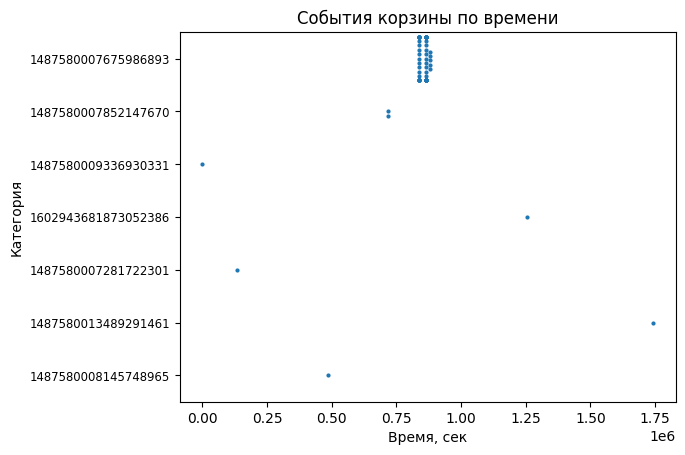

In [25]:
user_id = 475107397

one_user_events = user_events[user_events['user_id'] == user_id]
one_user_events = one_user_events[['event_time', 'category_id', 'event_type']]
one_user_events['event_time'] = pd.to_datetime(one_user_events['event_time'])

one_user_events = one_user_events[one_user_events['event_type'] == 'cart']

one_user_events['time_delta'] = one_user_events['event_time'] - one_user_events.iloc[0]['event_time']
one_user_events['time_delta_sec'] = one_user_events['time_delta'].apply(lambda x: x.total_seconds())
one_user_events['category_id_str'] = one_user_events['category_id'].apply(lambda x: str(x))

total_events = one_user_events.shape[0]
max_events_count = 50
select_events_count = int(total_events * 0.3) if total_events * 0.3 > max_events_count else max_events_count
one_user_events = one_user_events.iloc[np.random.choice(total_events, select_events_count, replace=False)]

ax = sns.swarmplot(data=one_user_events, x="time_delta_sec", y="category_id_str", size=3)
ax.set_title('События корзины по времени')
ax.set_xlabel('Время, сек')
ax.tick_params(axis='y', which='major', labelsize='small')
ax.set_ylabel('Категория')

plt.savefig(f'{RESULTS_PATH}/user_{user_id}_category_events.png', dpi=300)

2.0     43
3.0     36
4.0     10
11.0     9
9.0      6
1.0      5
5.0      5
17.0     5
10.0     4
Name: interval_sec, dtype: int64

(array([ 3., 48., 53., 25., 27., 22., 10.,  4.,  3.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  0.,  4.,  2.,  2.]),
 array([0.        , 0.2844598 , 0.56891961, 0.85337941, 1.13783921,
        1.42229901, 1.70675882, 1.99121862, 2.27567842, 2.56013822,
        2.84459803, 3.12905783, 3.41351763, 3.69797743, 3.98243724,
        4.26689704, 4.55135684, 4.83581664, 5.12027645, 5.40473625,
        5.68919605]),
 <BarContainer object of 20 artists>)

Text(0.5, 0, 'log10(Время между событиями), log10(сек)')

Text(0, 0.5, 'Количество интервалов')

Text(0.5, 1.0, 'Интервалы событий пользователя 475107397')

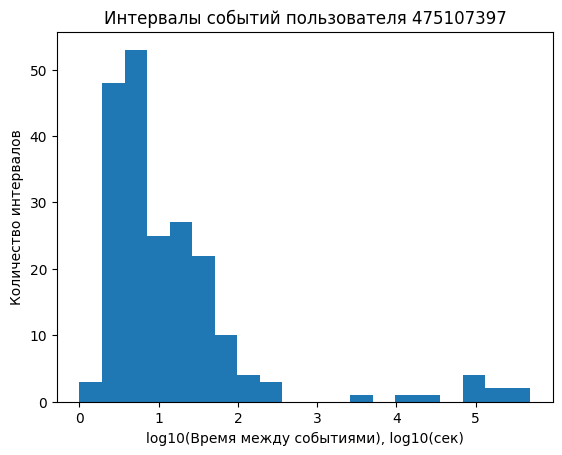

In [27]:
one_user_events = user_events[user_events['user_id'] == user_id]
one_user_events = one_user_events[['event_time', 'category_id', 'event_type']]
one_user_events['event_time'] = pd.to_datetime(one_user_events['event_time'])

one_user_events = one_user_events[one_user_events['event_type'] == 'cart']

one_user_events['time_delta'] = one_user_events['event_time'] - one_user_events.iloc[0]['event_time']
one_user_events['time_delta_sec'] = one_user_events['time_delta'].apply(lambda x: x.total_seconds())

def compute_events_time_difference(user_events_df):
    left = user_events_df[1:].reset_index(drop=True).add_suffix('_after')
    right = user_events_df[:len(user_events_df)-1].reset_index(drop=True).add_suffix('_before') 
    joined = pd.concat([left, right], axis=1)
    joined['interval_sec'] = joined['time_delta_sec_after'] - joined['time_delta_sec_before']
    return joined
    
one_user_time_diffs = compute_events_time_difference(one_user_events[['time_delta_sec']])
#ne_user_time_diffs

one_user_time_diffs['interval_sec'].value_counts()[:10]
#plt.hist(one_user_time_diffs_lt_10_sec, bins=20)
#plt.hist(one_user_time_diffs['interval_sec'], bins=20)

plt.hist(np.log10(one_user_time_diffs['interval_sec'] + 1), bins=20)
plt.xlabel('log10(Время между событиями), log10(сек)')
plt.ylabel('Количество интервалов')
plt.title(f'Интервалы событий пользователя {user_id}')

plt.savefig(f'{RESULTS_PATH}/user_{user_id}_events_interval_hist.png', dpi=300)

'Total groups count: 1'

user_id                          user_session  \
1124679  557850743  4ea2e30f-902e-470d-b0bd-f2a188e98170   
1125241  557850743  4ea2e30f-902e-470d-b0bd-f2a188e98170   
1125390  557850743  4ea2e30f-902e-470d-b0bd-f2a188e98170   
1300774  557850743  2c4eae90-ec40-4cdc-ac25-b29c4a6f8ad8   
1300964  557850743  2c4eae90-ec40-4cdc-ac25-b29c4a6f8ad8   
...            ...                                   ...   
4031662  557850743  7cba423c-0229-437b-9c72-cd5ce1f9b8fa   
4031717  557850743  7cba423c-0229-437b-9c72-cd5ce1f9b8fa   
4031748  557850743  7cba423c-0229-437b-9c72-cd5ce1f9b8fa   
4034159  557850743  7cba423c-0229-437b-9c72-cd5ce1f9b8fa   
4045310  557850743  7062eb81-5338-40ae-a072-e26f3792481d   

                       event_time  product_id event_type  price  \
1124679 2019-10-08 11:19:20+00:00     5598320       view  33.17   
1125241 2019-10-08 11:22:42+00:00     5561044       view   3.00   
1125390 2019-10-08 11:23:35+00:00     5789670       view   2.68   
1300774 2019-10-09 15:36:34+00:00     5827009       view   4.38   
1300964 2019-10-09 15:38:37+00:00     5854578       view  63.48   
...                           ...         ...        ...    ...   
4031662 2019-10-31 11:43:27+00:00     5641999       view  17.30   
4031717 2019-10-31 11:43:52+00:00     5826826       view  15.71   
4031748 2019-10-31 11:44:08+00:00     5641999       view  17.30   
4034159 2019-10-31 12:04:03+00:00       35342       view   3.98   
4045310 2019-10-31 13:44:52+00:00       44152       view   9.52   

                 category_id     brand  
1124679  1487580005595612013       NaN  
1125241  1487580005595612013       NaN  
1125390  1487580005595612013       NaN  
1300774  2193074740552270669       NaN  
1300964  1487580010645553231  jessnail  
...                      ...       ...  
4031662  1487580006317032337       NaN  
4031717  1487580006317032337       NaN  
4031748  1487580006317032337       NaN  
4034159  1487580012717539489       NaN  
4045310  1487580006317032337       NaN  

[609 rows x 8 columns]

user_id_after                    user_session_after  \
0        557850743  4ea2e30f-902e-470d-b0bd-f2a188e98170   
1        557850743  4ea2e30f-902e-470d-b0bd-f2a188e98170   
2        557850743  2c4eae90-ec40-4cdc-ac25-b29c4a6f8ad8   
3        557850743  2c4eae90-ec40-4cdc-ac25-b29c4a6f8ad8   
4        557850743  0fd30246-b7fd-4e72-8a7d-4e809f2fea78   
..             ...                                   ...   
603      557850743  7cba423c-0229-437b-9c72-cd5ce1f9b8fa   
604      557850743  7cba423c-0229-437b-9c72-cd5ce1f9b8fa   
605      557850743  7cba423c-0229-437b-9c72-cd5ce1f9b8fa   
606      557850743  7cba423c-0229-437b-9c72-cd5ce1f9b8fa   
607      557850743  7062eb81-5338-40ae-a072-e26f3792481d   

             event_time_after  product_id_after event_type_after  price_after  \
0   2019-10-08 11:22:42+00:00           5561044             view         3.00   
1   2019-10-08 11:23:35+00:00           5789670             view         2.68   
2   2019-10-09 15:36:34+00:00           5827009             view         4.38   
3   2019-10-09 15:38:37+00:00           5854578             view        63.48   
4   2019-10-09 15:42:50+00:00           5854578             view        63.48   
..                        ...               ...              ...          ...   
603 2019-10-31 11:43:27+00:00           5641999             view        17.30   
604 2019-10-31 11:43:52+00:00           5826826             view        15.71   
605 2019-10-31 11:44:08+00:00           5641999             view        17.30   
606 2019-10-31 12:04:03+00:00             35342             view         3.98   
607 2019-10-31 13:44:52+00:00             44152             view         9.52   

       category_id_after brand_after  user_id_before  \
0    1487580005595612013         NaN       557850743   
1    1487580005595612013         NaN       557850743   
2    2193074740552270669         NaN       557850743   
3    1487580010645553231    jessnail       557850743   
4    1487580010645553231    jessnail       557850743   
..                   ...         ...             ...   
603  1487580006317032337         NaN       557850743   
604  1487580006317032337         NaN       557850743   
605  1487580006317032337         NaN       557850743   
606  1487580012717539489         NaN       557850743   
607  1487580006317032337         NaN       557850743   

                      user_session_before         event_time_before  \
0    4ea2e30f-902e-470d-b0bd-f2a188e98170 2019-10-08 11:19:20+00:00   
1    4ea2e30f-902e-470d-b0bd-f2a188e98170 2019-10-08 11:22:42+00:00   
2    4ea2e30f-902e-470d-b0bd-f2a188e98170 2019-10-08 11:23:35+00:00   
3    2c4eae90-ec40-4cdc-ac25-b29c4a6f8ad8 2019-10-09 15:36:34+00:00   
4    2c4eae90-ec40-4cdc-ac25-b29c4a6f8ad8 2019-10-09 15:38:37+00:00   
..                                    ...                       ...   
603  7cba423c-0229-437b-9c72-cd5ce1f9b8fa 2019-10-31 11:43:24+00:00   
604  7cba423c-0229-437b-9c72-cd5ce1f9b8fa 2019-10-31 11:43:27+00:00   
605  7cba423c-0229-437b-9c72-cd5ce1f9b8fa 2019-10-31 11:43:52+00:00   
606  7cba423c-0229-437b-9c72-cd5ce1f9b8fa 2019-10-31 11:44:08+00:00   
607  7cba423c-0229-437b-9c72-cd5ce1f9b8fa 2019-10-31 12:04:03+00:00   

     product_id_before event_type_before  price_before   category_id_before  \
0              5598320              view         33.17  1487580005595612013   
1              5561044              view          3.00  1487580005595612013   
2              5789670              view          2.68  1487580005595612013   
3              5827009              view          4.38  2193074740552270669   
4              5854578              view         63.48  1487580010645553231   
..                 ...               ...           ...                  ...   
603            5861277              view         21.27  1487580006317032337   
604            5641999              view         17.30  1487580006317032337   
605            5826826              view         15.71  148758000631703233

/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 21.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 29.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='event_time_before', ylabel='event_type_before'>

/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 32.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 19.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/Valentin/mldev-recommender-systems-experiment/venv/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 46.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


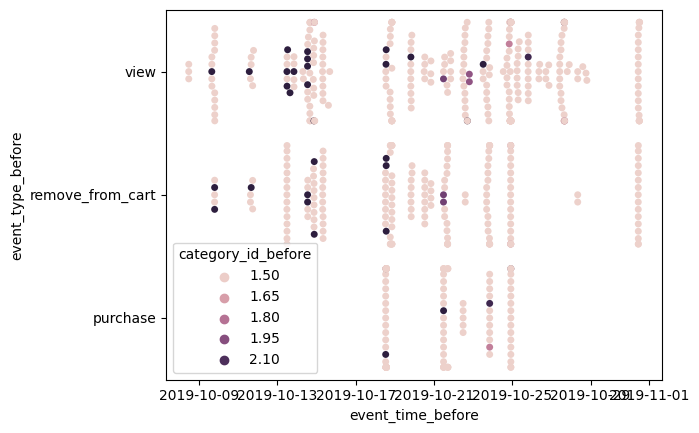

In [35]:
# todo это черновик, расчет времени между событиями у пользователей

user_events = user_events[user_events['user_id'] == 557850743]

user_groups_df = user_events.groupby(['user_id'])

# убрать лишние столбцы
# тот же анализ для части событий
# 

def compute_events_time_difference(user_events_df):
    left = user_events_df[1:].reset_index(drop=True).add_suffix('_after')
    right = user_events_df[:len(user_events_df)-1].reset_index(drop=True).add_suffix('_before') 
    joined = pd.concat([left, right], axis=1)
    joined['interval_sec'] = joined['event_time_after'] - joined['event_time_before']
    joined['interval_sec'] = joined['interval_sec'].apply(lambda x: x.total_seconds())
    joined
    return joined    


f'Total groups count: {len(user_groups_df)}'

result = pd.DataFrame()
i = 0

for group_name, user_group_df in user_groups_df:
    
    i += 1
    if i % 1000 == 0:
        i
    
    user_group_df['event_time'] = pd.to_datetime(user_group_df['event_time'])
    sorted_user_events = user_group_df.sort_values(by=['event_time'], kind='mergesort')
    sorted_user_events
    if len(sorted_user_events) <= 1:
        # skip single event users
        continue
        
    user_time_diffs = compute_events_time_difference(sorted_user_events)
    user_time_diffs
    sns.swarmplot(data=user_time_diffs, x="event_time_before", y="event_type_before", hue="category_id_before")
#     return combined.groupby(['event_type_before', 'event_type_after'])['interval_sec'].agg(['count',  'sum'])
#     #print(user_product_matrix)
#     result = user_product_matrix.add(result, fill_value=0)



# result = result.reset_index()

# распределение времени по отдельным пользователям с фильтром по событиям разного типа
# то же но для всей выборки - видимо рассчитать статистики и их распределение для всей выборки
# сравнить статистики - как изменится, если брать разные подмножества событий
# для подвыборки с учетом diversity
# один алгоритм конструирования таблицы